In [1]:
##Load an image
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import pims
import trackpy as tp
from pims import Frame
from scipy.misc import imsave
from scipy.misc import imread
shot = 115
picL = 18333
picR = 18158
v0L = imread('./Data/Shot{}/Clean_Data_Shot{}_Cam_{}/FrameL_sum.tif'.format(shot,shot,picL))
v0R = imread('./Data/Shot{}/Clean_Data_Shot{}_Cam_{}/FrameR_sum.tif'.format(shot,shot,picR))
bk0L = imread('./Data/Shot{}/Clean_Data_Shot{}_Cam_{}/FrameL0.tif'.format(shot,shot,picL))
bk0R = imread('./Data/Shot{}/Clean_Data_Shot{}_Cam_{}/FrameR0.tif'.format(shot,shot,picR))

In [2]:
sift = cv2.SIFT()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(bk0L,None)
kp2, des2 = sift.detectAndCompute(bk0R,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 1.1*n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

In [3]:
pts1 = np.asarray(pts1)
pts2 = np.asarray(pts2)

F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
N=50
t = np.arange(100)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]
a1 = pd.DataFrame(pts1)
a1.columns = ['XL','YL']
print(a1)
a2 = pd.DataFrame(pts2)
a2.columns = ['XR','YR']
print(a2)
a1.to_csv("calL.csv")
a2.to_csv("calR.csv")

plt.figure(figsize=[12,12])
plt.imshow(bk0L)
#plt.scatter(pts1[:,0],pts1[:,1], marker='^',cmap=t)
plt.savefig("L.png")
#plt.show()
plt.figure(figsize=[12,12])
plt.imshow(bk0R)
#plt.scatter(pts2[:,0],pts2[:,1], marker='o',cmap=t)
#plt.show()
plt.savefig("R.png")

            XL          YL
0   556.290955  418.124054
1   556.290955  418.124054
2   561.229248  419.337250
3   545.435364  431.766632
4   555.960022  441.722870
5   552.222412  442.391693
6   552.222412  442.391693
7   548.642212  442.878998
8   558.301208  442.952301
9   632.533081  367.768829
10  632.533081  367.768829
11  616.700317  378.170502
12  593.959167  397.876526
13  742.487122  402.259064
14  590.790649  410.036621
15  564.713562  419.520477
16  564.713562  419.520477
17  572.116089  419.694885
18  757.853699  419.743073
19  757.853699  419.743073
20  741.419556  422.008728
21  753.499573  423.304932
22  739.702881  425.684418
23  548.318115  436.634430
24  568.856628  444.466736
25  553.529968  445.689880
26  623.071228  373.719666
27  598.887329  378.851410
28  624.488281  383.098358
29  624.488281  383.098358
30  591.607544  406.306854
31  561.368896  415.550262
32  561.368896  415.550262
33  561.368896  415.550262
34  748.558411  423.781891
35  560.777832  452.675262
3

[[ 556.29095459  418.12405396]
 [ 556.29095459  418.12405396]
 [ 561.22924805  419.33724976]
 [ 545.43536377  431.76663208]
 [ 555.96002197  441.72286987]
 [ 552.22241211  442.39169312]
 [ 552.22241211  442.39169312]
 [ 548.64221191  442.8789978 ]
 [ 558.3012085   442.95230103]
 [ 632.53308105  367.76882935]
 [ 632.53308105  367.76882935]
 [ 616.70031738  378.17050171]
 [ 593.95916748  397.87652588]
 [ 742.48712158  402.25906372]
 [ 590.79064941  410.03662109]
 [ 564.71356201  419.52047729]
 [ 564.71356201  419.52047729]
 [ 572.11608887  419.69488525]
 [ 757.85369873  419.74307251]
 [ 757.85369873  419.74307251]
 [ 741.41955566  422.00872803]
 [ 753.49957275  423.30493164]
 [ 739.70288086  425.68441772]
 [ 548.31811523  436.63442993]
 [ 568.85662842  444.46673584]
 [ 553.52996826  445.68988037]
 [ 623.07122803  373.71966553]
 [ 598.8873291   378.85140991]
 [ 624.48828125  383.09835815]
 [ 624.48828125  383.09835815]
 [ 591.60754395  406.30685425]
 [ 561.36889648  415.55026245]
 [ 561.3

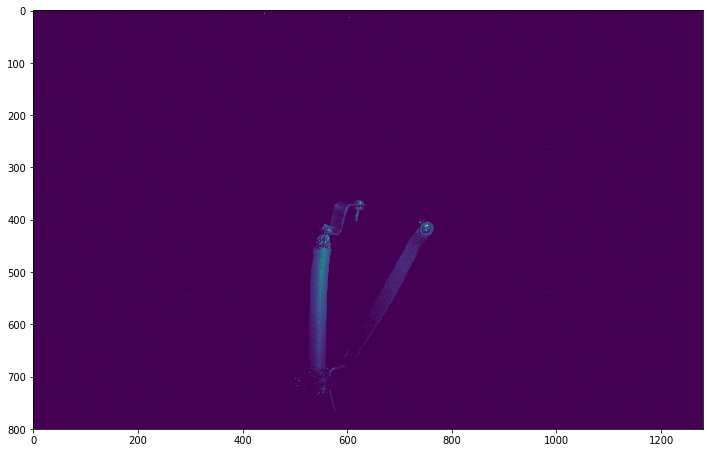

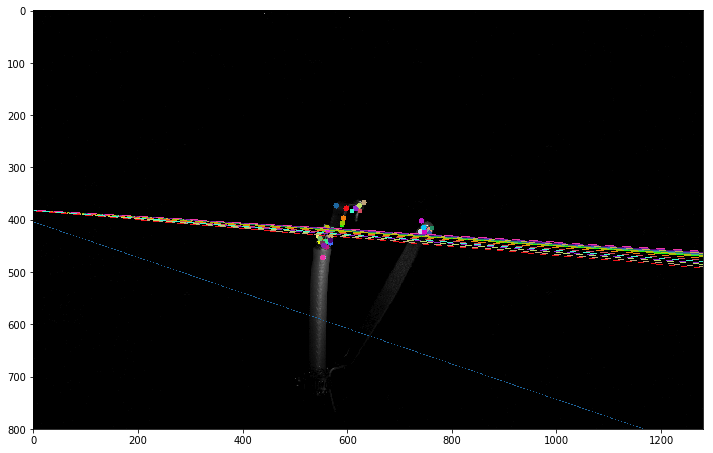

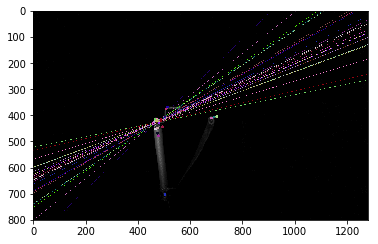

In [4]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        #print(r)
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])     
        cv2.line(img1, (x0,y0), (x1,y1), color,1)
        cv2.circle(img1,tuple(pt1),5,color,-1)
        cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

lines1 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2).astype('float32'), 2,F)
lines1 = lines1.reshape(-1,3)
print(pts1)
print(lines1)
img5,img6 = drawlines(bk0L,bk0R,lines1,pts1.astype('int32'),pts2.astype('int32'))

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2).astype('float32'), 1,F)
lines2 = lines2.reshape(-1,3)
print(pts2)
print(lines2)
img3,img4 = drawlines(bk0R,bk0L,lines2,pts2.astype('int32'),pts1.astype('int32'))


plt.imshow(img5)
plt.show()
plt.imshow(img3)
plt.show()